In [1]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt, yaml
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
import pandas as pd
from PIL import Image
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as Func
from datetime import datetime
from torchvision.io import read_image


In [9]:
def load_class_info(yaml_file):
    with open(yaml_file, 'r') as file:
            class_info = yaml.safe_load(file)
    return class_info['classes']
    
def label_transform_ecc(classes, labels, codewords):
    class_to_index = {class_name: index for index, class_name in enumerate(classes)}
    print(codewords)
    target = np.zeros(len(codewords[0]), dtype=int)
    for label in labels:
        if label in class_to_index:
            index = class_to_index[label]
            target = codewords[index]
    return target

def ecc_encode(label, ecc_codes):
    class_index = label.index(1)  # Assuming label is initially one-hot
    return ecc_codes[class_index]
    
def transform(image, keypoints, one_hot_label, num_classes, image_size=(224, 224), fusion='concat'):
    transform_ops = transforms.Compose([
        transforms.Resize(image_size),
    ])
    image = transform_ops(image)
    keypoints = torch.tensor(keypoints).float()
    one_hot_label = torch.tensor(one_hot_label).float()
    one_hot_channel = one_hot_label.unsqueeze(1).unsqueeze(2).expand(len(one_hot_label), image_size[0], image_size[1])
    one_hot_channel = one_hot_channel.sum(dim=0, keepdim=True)
    
    input_combined = torch.cat((image, one_hot_channel), dim=0)

    if fusion == 'concat':
        input_combined = torch.cat((image, one_hot_channel), dim=0)

    elif fusion == 'add':
        if image.shape[0] == 3:
            padding = torch.zeros_like(image[0]).unsqueeze(0)
            padded_one_hot_channel = torch.cat([one_hot_channel, padding, padding], dim=0)
        input_combined = image + padded_one_hot_channel

    elif fusion == 'multiply':
        if image.shape[0] == 3:
            one_hot_channel = one_hot_channel.repeat(3, 1, 1)
        input_combined = image * one_hot_channel
        
    if fusion == 'concat':
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.0], std=[0.229, 0.224, 0.225, 1.0])
    else:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    input_combined = normalize(input_combined)
    
    return input_combined, keypoints

def denormalize_image(image):
    denormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    image = denormalize(image)
    image = torch.clamp(image, 0, 1)
    return image

def visualize_keypoints(image, keypoints):
    image = denormalize_image(image)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=10, marker='.', c='r')
    plt.show()

In [10]:
class ClassDataset(Dataset):
    def __init__(self, dataset_folder, class_info_file, transform=None, label_transform=None, fusion_type='concat'):
        self.dataset_folder = dataset_folder
        self.transform = transform
        self.label_transform = label_transform
        self.imgs_files = self.load_data(dataset_folder)
        self.class_names = load_class_info(class_info_file)
        self.num_classes = len(self.class_names)
        self.fusion_type = fusion_type

    def load_data(self, dataset_folder):
        images_path = os.path.join(self.dataset_folder,"images/")
        annotations_path = os.path.join(self.dataset_folder,"annotations/")
        j_data = []
        for file in os.listdir(images_path):
            if file.endswith(".jpg"):
                json_path = os.path.join(annotations_path, file.split('.')[0] + '.json')
                with open(json_path) as f:
                    json_load = json.load(f)
                    for item in json_load['shapes']:
                        points = [value for row in item['points'] for value in row]
                        j_data.append({'image':  os.path.join(images_path,file),
                                     'label': item['label'],
                                     'points':points })
        json_data = pd.DataFrame(j_data)
        return json_data

    def get_keypoint(self, bboxes):
        centers = []
        for bbox in bboxes:
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            centers.append((center_x, center_y))
        return centers
    
    def __len__(self):
        return len(self.imgs_files)

    def __getitem__(self, idx):
        target = {}
        img_path, label, bboxes_original = self.imgs_files.iloc[idx]
        label = [label]
        bboxes_original = [bboxes_original]
        keypoint_original = self.get_keypoint(bboxes_original)
        img_original = read_image(img_path).float() / 255.0

        if self.transform:
            label_transform = self.label_transform(self.class_names,label, self.num_classes)
            img, target['keypoints'] = self.transform(img_original, keypoint_original, label_transform, self.num_classes, fusion=self.fusion_type)
            target['labels'] = torch.as_tensor(label_transform, dtype=torch.int64)
        else:
            # img, bboxes = img_original, bboxes_original
            img, target['keypoints'] = img_original, keypoint_original
            target['labels'] = label

        return img, target, img_original
    

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

# class_config_path = '../config/class.yaml'
class_config_path = '../../config/formated_class.yaml'
KEYPOINTS_FOLDER_TRAIN = '../../dataset/robocup_all_test/'
# KEYPOINTS_FOLDER_TRAIN = '../../dataset/robocup_test_dataset/'
train_path = os.path.join(KEYPOINTS_FOLDER_TRAIN,"train/")
val_path = os.path.join(KEYPOINTS_FOLDER_TRAIN,"val/")

fusion_type = 'concat'
# fusion_type = 'add'
# fusion_type = 'multiply'

train_dataset = ClassDataset(train_path, class_config_path, transform=transform, label_transform=label_transform_ecc, fusion_type=fusion_type)
valid_dataset = ClassDataset(val_path, class_config_path, transform=transform, label_transform=label_transform_ecc, fusion_type=fusion_type)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [12]:
iterator = iter(valid_loader)
images, targets, img = next(iterator)
image_number = 0
num_channels = images[image_number].shape[0]

print("concatenated input size = ", images[image_number].shape)
print(f"keypoint = {targets[image_number]['keypoints']}\nlabel = {targets[image_number]['labels']}")

visualize_keypoints(img[image_number], targets[image_number]['keypoints'])

18


TypeError: 'int' object is not subscriptable

In [98]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=20, num_keypoints=1, num_channels=4): 
        super(CustomResNet50, self).__init__()
        
        self.num_keypoints = num_keypoints
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc_cls = nn.Linear(self.resnet50.fc.in_features, num_classes)
        self.fc_kpts = nn.Linear(self.resnet50.fc.in_features, self.num_keypoints * 2)
        self.resnet50.fc = nn.Identity()
        
    def forward(self, x):
        features = self.resnet50(x)
        class_outputs = self.fc_cls(features)
        keypoint_outputs = self.fc_kpts(features)
        return class_outputs, keypoint_outputs.reshape(-1, self.num_keypoints, 2)

In [99]:
def train_model(model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=25):
    train_losses = []
    valid_losses = []
    key_train_losses = []
    key_valid_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_kpt_loss = 0.0

        for images, targets, labels in train_loader:
            labels = [target['labels'].to(device) for target in targets]
            images = torch.stack(images).to(device)
            ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

            labels_tensor = torch.stack(labels)
            class_indices = torch.argmax(labels_tensor, dim=1)

            optimizer.zero_grad()

            class_outputs, keypoint_outputs = model(images)
            
            loss_cls = criterion_cls(class_outputs, class_indices)
            loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
            # loss_kpt = LaplaceNLLLoss(keypoint_outputs, ground_truth_keypoints, 0.01)
            total_loss = loss_kpt + loss_cls # Combine losses for backpropagation
            total_loss.backward()
            optimizer.step()
            total_train_loss += loss_cls.item()
            total_kpt_loss += loss_kpt.item()

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_kpt_loss = total_kpt_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Train Keypoint Loss: {avg_kpt_loss}')

        model.eval()
        total_val_loss = 0.0
        total_val_kpt_loss = 0.0

        with torch.no_grad():
            for images, targets, labels in valid_loader:
                labels = [target['labels'].to(device) for target in targets]
                images = torch.stack(images).to(device)
                ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

                labels_tensor = torch.stack(labels)
                class_indices = torch.argmax(labels_tensor, dim=1)

                class_outputs, keypoint_outputs = model(images)
                
                loss_cls = criterion_cls(class_outputs, class_indices)
                loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
                # loss_kpt = LaplaceNLLLoss(keypoint_outputs, ground_truth_keypoints, 0.01)
                
                total_val_loss += loss_cls.item() 
                total_val_kpt_loss += loss_kpt.item()

        avg_val_loss = total_val_loss / len(valid_loader.dataset)
        avg_val_kpt_loss = total_val_kpt_loss / len(valid_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}, Val Keypoint Loss: {avg_val_kpt_loss}')
        
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_val_loss)
        key_train_losses.append(avg_kpt_loss)
        key_valid_losses.append(avg_val_kpt_loss)

    return model, train_losses, key_train_losses, valid_losses, key_valid_losses  # Optionally return the model

In [100]:
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
iterator = iter(valid_loader)
combined_input, targets, img = next(iterator)
image_number = 0

num_channels = combined_input[image_number].shape[0]
num_classes = len(load_class_info(class_config_path))
model = CustomResNet50(num_classes=num_classes, num_keypoints=1, num_channels=num_channels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion_cls = nn.CrossEntropyLoss()
criterion_kpt = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [101]:
epochs_train = 100
trained_model, train_loss, key_train_loss, val_loss, key_val_loss = train_model(model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=epochs_train)
# train_model(model, criterion, optimizer, num_epochs)
torch.save(model.state_dict(), './models/resnet50_conditional_concat_3.pth')

Epoch 1/100, Training Loss: 0.08399957083004378, Train Keypoint Loss: 2518.2775424445344
Epoch 1/100, Validation Loss: 0.08883401391835048, Val Keypoint Loss: 1919.0519851158406
Epoch 2/100, Training Loss: 0.08296848904518854, Train Keypoint Loss: 876.4438106652462
Epoch 2/100, Validation Loss: 0.08955954631854748, Val Keypoint Loss: 612.8852244410022
Epoch 3/100, Training Loss: 0.08635280723179574, Train Keypoint Loss: 422.4382477467194
Epoch 3/100, Validation Loss: 0.08078523237129738, Val Keypoint Loss: 569.7475101865571
Epoch 4/100, Training Loss: 0.08739469784162777, Train Keypoint Loss: 415.63976416649757
Epoch 4/100, Validation Loss: 0.08204914989142582, Val Keypoint Loss: 594.4013377222522
Epoch 5/100, Training Loss: 0.08603522465342567, Train Keypoint Loss: 405.63299745501894
Epoch 5/100, Validation Loss: 0.0921981642986166, Val Keypoint Loss: 534.0362611967942
Epoch 6/100, Training Loss: 0.08788620961176885, Train Keypoint Loss: 393.7532456963609
Epoch 6/100, Validation Loss:

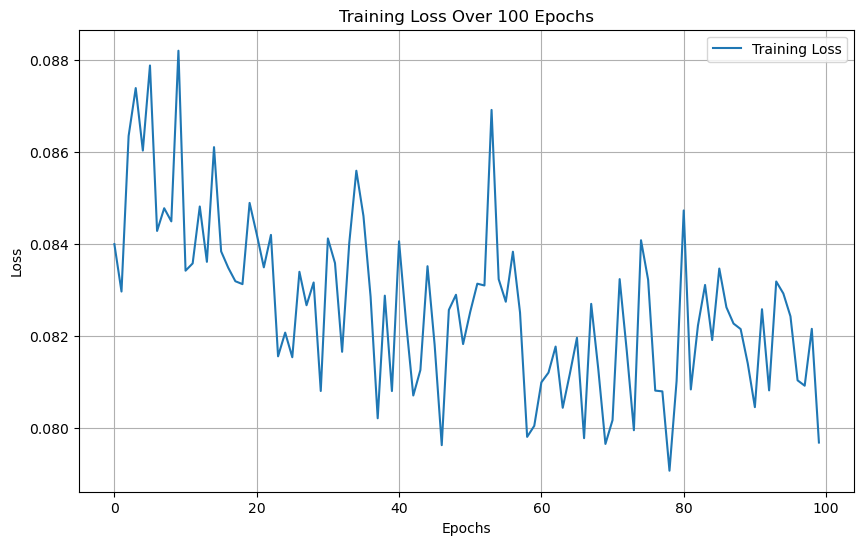

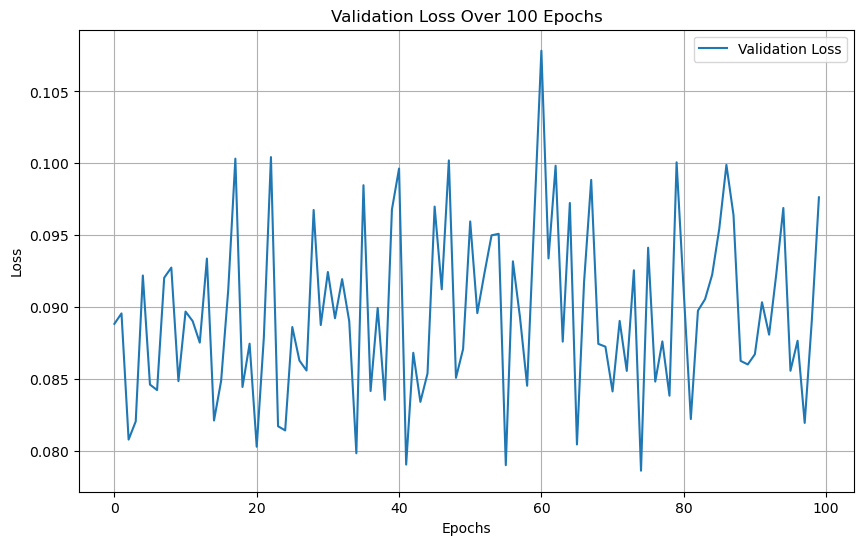

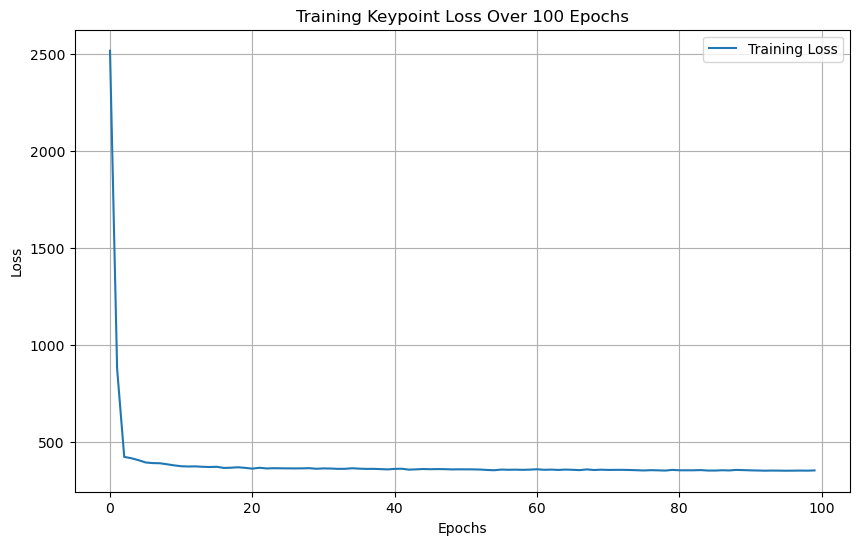

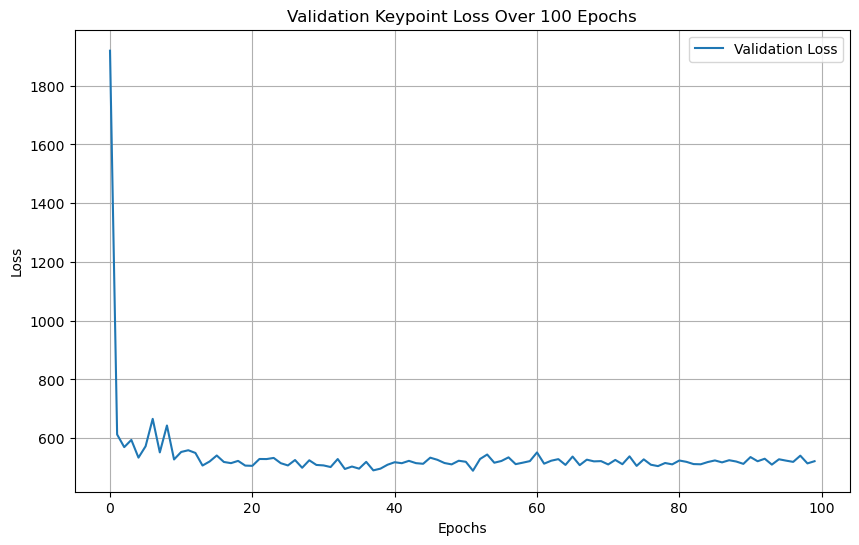

In [102]:
def plot_train_losses(train_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

def plot_val_losses(valid_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Validation Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

def plot_train_kpt_losses(train_kpt_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_kpt_losses, label='Training Loss')
    plt.title('Training Keypoint Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

def plot_val_kpt_losses(val_kpt_losses, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(val_kpt_losses, label='Validation Loss')
    plt.title('Validation Keypoint Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

path_train_loss = "./plots/train_losses_resnet50_conditional_"+fusion_type+"_2.png"
path_val_loss = "./plots/val_losses_resnet50_conditional_add_"+fusion_type+"_2.png"
path_train_kpt = "./plots/train_kpt_losses_resnet50_conditional_"+fusion_type+"_2.png"
path_val_kpt = "./plots/val_kpt_losses_resnet50_conditional_"+fusion_type+"_2.png"

plot_train_losses(train_loss, save_path=path_train_loss)
plot_val_losses(val_loss, save_path=path_val_loss)
plot_train_kpt_losses(key_train_loss, save_path=path_train_kpt)
plot_val_kpt_losses(key_val_loss, save_path=path_val_kpt)